# How to Run TARDIS with a Custom Packet Source


By default, TARDIS generates energy packets using its interface `BasePacketSource` class, which has a derived class `BlackBodySimpleSource`, which models the photosphere of the supernova as a perfect blackbody (see [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb)). However, users may create their own packet source, as will be shown in this notebook. In order to do this, a user must create a class (that inherits from `BasePacketSource`) and implement the following abstract functions:

- create_packet_radii (returns array of packet radii)
- create_packet_nus (returns array of packet frequencies)
- create_packet_mus (returns array of packet directions)
- create_packet_energies (returns array of packet energies. See [Energy Packet Initialization](../../physics/montecarlo/initialization.ipynb) for more information)
- create_packets (wrapper which calls the above 4 functions, and is the function used by external code)
- set_state_from_model (set the state of the source from a model object)

[Note: In this notebook, we have extended the `BlackBodySimpleSource` class because it already implements some of the above functions]

To use your packet source in a run of TARDIS, you must pass an instance of your class into the `run_tardis` function under the `packet_source` keyword argument.

.. note:: In both the `BlackBodySimpleSource` class and in the example here, all packets are generated at the same radius. This need not be true in general (though one call of the `create_packets` method will pick the same radius from the packet source state).

We show an example of how a custom packet source is used:


In [1]:
# Import necessary packages
import numpy as np
from tardis import constants as const
from astropy import units as u
from tardis.transport.montecarlo.packet_source import BlackBodySimpleSource
from tardis.transport.montecarlo.packet_collections import (
    PacketCollection,
)
from tardis import run_tardis
import matplotlib.pyplot as plt
from tardis.io.atom_data import download_atom_data

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
# Download the atomic data used for a run of TARDIS
download_atom_data("kurucz_cd23_chianti_H_He")

Atomic Data kurucz_cd23_chianti_H_He already exists in /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5. Will not download - override with force_download=True.


In [3]:
# Create a packet source class that contains a create_packets method
class TruncBlackbodySource(BlackBodySimpleSource):
    """
    Custom inner boundary source class to replace the Blackbody source
    with a truncated Blackbody source.

    Parameters
    ----------
    truncation_wavelength : float
        truncation wavelength in Angstrom.
        Only wavelengths higher than the truncation wavelength
        will be sampled.
    radius : float64
        Initial packet radius
    temperature : float
        Absolute Temperature.
    base_seed : int
        Base Seed for random number generator
    """

    def __init__(self, truncation_wavelength=None, **kwargs):
        self.truncation_wavelength = truncation_wavelength
        super().__init__(**kwargs)

    def create_packets(self, no_of_packets, drawing_sample_size=None, seed_offset=0, *args, **kwargs):
        """
        Packet source that generates a truncated Blackbody source.

        Parameters
        ----------
        no_of_packets : int
            number of packets to be created

        Returns
        -------
        array
            Packet radii
        array
            Packet frequencies
        array
            Packet directions
        array
            Packet energies
        """

        self._reseed(self.base_seed + seed_offset)
        packet_seeds = self.rng.choice(
            self.MAX_SEED_VAL, no_of_packets, replace=True
        )

        # Makes uniform array of packet radii from blackbody source
        radii = self.create_packet_radii(no_of_packets, *args, **kwargs)

        # Use mus and energies from normal blackbody source.
        mus = self.create_packet_mus(no_of_packets, *args, **kwargs)
        energies = self.create_packet_energies(no_of_packets, *args, **kwargs)

        # If not specified, draw 2 times as many packets and reject any beyond no_of_packets.
        if drawing_sample_size is None:
            drawing_sample_size = 2 * no_of_packets

        # Blackbody will be truncated below truncation_wavelength / above truncation_frequency.
        truncation_frequency = (
            u.Quantity(self.truncation_wavelength, u.Angstrom)
            .to(u.Hz, equivalencies=u.spectral())
        )

        # Draw nus from blackbody distribution and reject based on truncation_frequency.
        # If more nus.shape[0] > no_of_packets use only the first no_of_packets.
        nus = self.create_packet_nus(drawing_sample_size, *args, **kwargs)
        nus = nus[nus < truncation_frequency][:no_of_packets]

        # Only required if the truncation wavelength is too big compared to the maximum
        # of the blackbody distribution. Keep sampling until nus.shape[0] > no_of_packets.
        while nus.shape[0] < no_of_packets:
            additional_nus = self.create_packet_nus(drawing_sample_size, *args, **kwargs)
            mask = additional_nus < truncation_frequency
            additional_nus = additional_nus[mask][:no_of_packets]
            nus = np.hstack([nus, additional_nus])[:no_of_packets]

        radiation_field_luminosity = (
            self.calculate_radfield_luminosity().to(u.erg / u.s).value
        )

        return PacketCollection(radii, nus, mus, energies, packet_seeds, radiation_field_luminosity)

In [4]:
# Call an instance of the packet source class
packet_source = TruncBlackbodySource(
    truncation_wavelength=2000, base_seed=53253
)

We now run TARDIS both with and without our custom packet source, and we compare the results:


In [5]:
mdl = run_tardis("tardis_example.yml", packet_source=packet_source)
mdl_norm = run_tardis("tardis_example.yml")

[tardis.io.model.parse_atom_data][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (parse_atom_data.py:40)


[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:34)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:262)


[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist_atoms, linelist_molecules (base.py:266)


[tardis.io.model.parse_density_configuration][WARNING]  
	Number of density points larger than number of shells. Assuming inner point irrelevant (parse_density_configuration.py:114)


[tardis.model.matter.decay][INFO   ]  
	Decaying abundances for 1123200.0 seconds (decay.py:101)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:448)


[py.warnings         ][WARNING]  
	/home/runner/work/tardis/tardis/tardis/transport/montecarlo/montecarlo_main_loop.py:123: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  vpacket_collection = vpacket_collections[i]
 (warnings.py:112)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.030e+42 erg / s
	Luminosity absorbed  = 2.580e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03 K,9.39e+03 K,0.4,0.684
5,9.85e+03 K,9.72e+03 K,0.211,0.243
10,9.78e+03 K,9.63e+03 K,0.143,0.145
15,9.71e+03 K,9.31e+03 K,0.105,0.11


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10671.887 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.501e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.39e+03 K,9.62e+03 K,0.684,0.837
5,9.72e+03 K,9.88e+03 K,0.243,0.301
10,9.63e+03 K,9.81e+03 K,0.145,0.179
15,9.31e+03 K,9.66e+03 K,0.11,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10671.887 K
	Expected t_inner for next iteration = 10664.263 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.065e+43 erg / s
	Luminosity absorbed  = 3.440e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.62e+03 K,9.64e+03 K,0.837,0.818
5,9.88e+03 K,9.88e+03 K,0.301,0.303
10,9.81e+03 K,9.8e+03 K,0.179,0.179
15,9.66e+03 K,9.64e+03 K,0.127,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10664.263 K
	Expected t_inner for next iteration = 10650.425 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.429e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.64e+03 K,9.64e+03 K,0.818,0.817
5,9.88e+03 K,9.9e+03 K,0.303,0.3
10,9.8e+03 K,9.82e+03 K,0.179,0.177
15,9.64e+03 K,9.63e+03 K,0.128,0.129


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.425 K
	Expected t_inner for next iteration = 10652.695 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.060e+43 erg / s
	Luminosity absorbed  = 3.425e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.64e+03 K,9.66e+03 K,0.817,0.811
5,9.9e+03 K,9.98e+03 K,0.3,0.29
10,9.82e+03 K,9.91e+03 K,0.177,0.172
15,9.63e+03 K,9.66e+03 K,0.129,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10652.695 K
	Expected t_inner for next iteration = 10650.719 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.464e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.66e+03 K,9.67e+03 K,0.811,0.807
5,9.98e+03 K,9.97e+03 K,0.29,0.288
10,9.91e+03 K,9.85e+03 K,0.172,0.174
15,9.66e+03 K,9.68e+03 K,0.126,0.125


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.719 K
	Expected t_inner for next iteration = 10661.147 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.068e+43 erg / s
	Luminosity absorbed  = 3.390e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.67e+03 K,9.7e+03 K,0.807,0.796
5,9.97e+03 K,9.9e+03 K,0.288,0.302
10,9.85e+03 K,9.84e+03 K,0.174,0.177
15,9.68e+03 K,9.66e+03 K,0.125,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10661.147 K
	Expected t_inner for next iteration = 10638.527 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.7e+03 K,9.68e+03 K,0.796,0.803
5,9.9e+03 K,1e+04 K,0.302,0.286
10,9.84e+03 K,9.94e+03 K,0.177,0.17
15,9.66e+03 K,9.66e+03 K,0.128,0.125


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.527 K
	Expected t_inner for next iteration = 10650.528 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.404e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03 K,9.64e+03 K,0.803,0.815
5,1e+04 K,9.92e+03 K,0.286,0.296
10,9.94e+03 K,9.83e+03 K,0.17,0.178
15,9.66e+03 K,9.65e+03 K,0.125,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.528 K
	Expected t_inner for next iteration = 10646.046 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.054e+43 erg / s
	Luminosity absorbed  = 3.447e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.64e+03 K,9.67e+03 K,0.815,0.811
5,9.92e+03 K,9.96e+03 K,0.296,0.288
10,9.83e+03 K,9.95e+03 K,0.178,0.168
15,9.65e+03 K,9.65e+03 K,0.128,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10646.046 K
	Expected t_inner for next iteration = 10658.702 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.449e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.67e+03 K,9.65e+03 K,0.811,0.812
5,9.96e+03 K,9.95e+03 K,0.288,0.29
10,9.95e+03 K,9.85e+03 K,0.168,0.175
15,9.65e+03 K,9.65e+03 K,0.126,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10658.702 K
	Expected t_inner for next iteration = 10654.370 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.442e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.65e+03 K,9.65e+03 K,0.812,0.815
5,9.95e+03 K,9.96e+03 K,0.29,0.292
10,9.85e+03 K,9.89e+03 K,0.175,0.174
15,9.65e+03 K,9.6e+03 K,0.127,0.13


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.370 K
	Expected t_inner for next iteration = 10654.749 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.461e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.65e+03 K,9.67e+03 K,0.815,0.805
5,9.96e+03 K,9.92e+03 K,0.292,0.293
10,9.89e+03 K,9.9e+03 K,0.174,0.172
15,9.6e+03 K,9.64e+03 K,0.13,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.749 K
	Expected t_inner for next iteration = 10659.019 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.068e+43 erg / s
	Luminosity absorbed  = 3.386e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.67e+03 K,9.69e+03 K,0.805,0.798
5,9.92e+03 K,1e+04 K,0.293,0.293
10,9.9e+03 K,9.91e+03 K,0.172,0.174
15,9.64e+03 K,9.6e+03 K,0.127,0.13


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10659.019 K
	Expected t_inner for next iteration = 10638.289 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.417e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.69e+03 K,9.63e+03 K,0.798,0.816
5,1e+04 K,9.88e+03 K,0.293,0.299
10,9.91e+03 K,9.82e+03 K,0.174,0.176
15,9.6e+03 K,9.62e+03 K,0.13,0.128


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.289 K
	Expected t_inner for next iteration = 10653.183 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.458e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.63e+03 K,9.68e+03 K,0.816,0.808
5,9.88e+03 K,9.96e+03 K,0.299,0.29
10,9.82e+03 K,9.84e+03 K,0.176,0.176
15,9.62e+03 K,9.64e+03 K,0.128,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.183 K
	Expected t_inner for next iteration = 10658.530 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.465e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03 K,9.68e+03 K,0.808,0.804
5,9.96e+03 K,1e+04 K,0.29,0.286
10,9.84e+03 K,9.95e+03 K,0.176,0.167
15,9.64e+03 K,9.7e+03 K,0.127,0.124


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10658.530 K
	Expected t_inner for next iteration = 10658.730 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.064e+43 erg / s
	Luminosity absorbed  = 3.425e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.68e+03 K,9.64e+03 K,0.804,0.809
5,1e+04 K,9.92e+03 K,0.286,0.294
10,9.95e+03 K,9.88e+03 K,0.167,0.174
15,9.7e+03 K,9.65e+03 K,0.124,0.127


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10658.730 K
	Expected t_inner for next iteration = 10647.215 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.430e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.64e+03 K,9.72e+03 K,0.809,0.787
5,9.92e+03 K,9.97e+03 K,0.294,0.292
10,9.88e+03 K,9.92e+03 K,0.174,0.17
15,9.65e+03 K,9.67e+03 K,0.127,0.126


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.215 K
	Expected t_inner for next iteration = 10654.133 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 19 iterations 
	Simulation took 59.93 s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.424e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.io.model.parse_atom_data][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (parse_atom_data.py:40)


[tardis.io.atom_data.util][INFO   ]  
	
	Atom Data kurucz_cd23_chianti_H_He.h5 not found in local path.
	Exists in TARDIS Data repo /home/runner/Downloads/tardis-data/kurucz_cd23_chianti_H_He.h5 (util.py:34)


[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:262)


[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist_atoms, linelist_molecules (base.py:266)


[tardis.io.model.parse_density_configuration][WARNING]  
	Number of density points larger than number of shells. Assuming inner point irrelevant (parse_density_configuration.py:114)


[tardis.model.matter.decay][INFO   ]  
	Decaying abundances for 1123200.0 seconds (decay.py:101)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:448)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.942e+42 erg / s
	Luminosity absorbed  = 2.659e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.93e+03 K,1.01e+04 K,0.4,0.507
5,9.85e+03 K,1.02e+04 K,0.211,0.197
10,9.78e+03 K,1.01e+04 K,0.143,0.117
15,9.71e+03 K,9.87e+03 K,0.105,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9933.952 K
	Expected t_inner for next iteration = 10703.212 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.071e+43 erg / s
	Luminosity absorbed  = 3.576e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04 K,1.08e+04 K,0.507,0.525
5,1.02e+04 K,1.1e+04 K,0.197,0.203
10,1.01e+04 K,1.08e+04 K,0.117,0.125
15,9.87e+03 K,1.05e+04 K,0.0869,0.0933


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10703.212 K
	Expected t_inner for next iteration = 10673.712 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.074e+43 erg / s
	Luminosity absorbed  = 3.391e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.08e+04 K,1.1e+04 K,0.525,0.483
5,1.1e+04 K,1.12e+04 K,0.203,0.189
10,1.08e+04 K,1.1e+04 K,0.125,0.118
15,1.05e+04 K,1.06e+04 K,0.0933,0.0895


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10673.712 K
	Expected t_inner for next iteration = 10635.953 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.058e+43 erg / s
	Luminosity absorbed  = 3.352e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.483,0.469
5,1.12e+04 K,1.12e+04 K,0.189,0.182
10,1.1e+04 K,1.1e+04 K,0.118,0.113
15,1.06e+04 K,1.07e+04 K,0.0895,0.0861


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10635.953 K
	Expected t_inner for next iteration = 10638.407 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.055e+43 erg / s
	Luminosity absorbed  = 3.399e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.469,0.479
5,1.12e+04 K,1.13e+04 K,0.182,0.178
10,1.1e+04 K,1.1e+04 K,0.113,0.113
15,1.07e+04 K,1.07e+04 K,0.0861,0.0839


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.407 K
	Expected t_inner for next iteration = 10650.202 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.398e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.479,0.47
5,1.13e+04 K,1.12e+04 K,0.178,0.185
10,1.1e+04 K,1.11e+04 K,0.113,0.112
15,1.07e+04 K,1.07e+04 K,0.0839,0.0856


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10650.202 K
	Expected t_inner for next iteration = 10645.955 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.382e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.47,0.47
5,1.12e+04 K,1.13e+04 K,0.185,0.178
10,1.11e+04 K,1.11e+04 K,0.112,0.112
15,1.07e+04 K,1.07e+04 K,0.0856,0.086


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10645.955 K
	Expected t_inner for next iteration = 10642.050 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.350e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.11e+04 K,0.47,0.472
5,1.13e+04 K,1.14e+04 K,0.178,0.175
10,1.11e+04 K,1.11e+04 K,0.112,0.111
15,1.07e+04 K,1.07e+04 K,0.086,0.084


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10642.050 K
	Expected t_inner for next iteration = 10636.106 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.052e+43 erg / s
	Luminosity absorbed  = 3.411e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.11e+04 K,0.472,0.469
5,1.14e+04 K,1.15e+04 K,0.175,0.17
10,1.11e+04 K,1.11e+04 K,0.111,0.109
15,1.07e+04 K,1.08e+04 K,0.084,0.0822


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.106 K
	Expected t_inner for next iteration = 10654.313 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.070e+43 erg / s
	Luminosity absorbed  = 3.335e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.1e+04 K,0.469,0.475
5,1.15e+04 K,1.14e+04 K,0.17,0.177
10,1.11e+04 K,1.11e+04 K,0.109,0.112
15,1.08e+04 K,1.06e+04 K,0.0822,0.0878


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10654.313 K
	Expected t_inner for next iteration = 10628.190 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.363e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.475,0.472
5,1.14e+04 K,1.12e+04 K,0.177,0.184
10,1.11e+04 K,1.1e+04 K,0.112,0.114
15,1.06e+04 K,1.06e+04 K,0.0878,0.0859


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10628.190 K
	Expected t_inner for next iteration = 10644.054 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.420e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.11e+04 K,0.472,0.467
5,1.12e+04 K,1.13e+04 K,0.184,0.176
10,1.1e+04 K,1.11e+04 K,0.114,0.11
15,1.06e+04 K,1.08e+04 K,0.0859,0.0821


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10644.054 K
	Expected t_inner for next iteration = 10653.543 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.062e+43 erg / s
	Luminosity absorbed  = 3.406e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.11e+04 K,0.467,0.466
5,1.13e+04 K,1.13e+04 K,0.176,0.18
10,1.11e+04 K,1.11e+04 K,0.11,0.111
15,1.08e+04 K,1.08e+04 K,0.0821,0.0841


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10653.543 K
	Expected t_inner for next iteration = 10647.277 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.063e+43 erg / s
	Luminosity absorbed  = 3.369e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.11e+04 K,0.466,0.469
5,1.13e+04 K,1.13e+04 K,0.18,0.182
10,1.11e+04 K,1.1e+04 K,0.111,0.113
15,1.08e+04 K,1.07e+04 K,0.0841,0.0854


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10647.277 K
	Expected t_inner for next iteration = 10638.875 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.053e+43 erg / s
	Luminosity absorbed  = 3.417e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.1e+04 K,0.469,0.484
5,1.13e+04 K,1.13e+04 K,0.182,0.181
10,1.1e+04 K,1.1e+04 K,0.113,0.113
15,1.07e+04 K,1.07e+04 K,0.0854,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10638.875 K
	Expected t_inner for next iteration = 10655.125 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.059e+43 erg / s
	Luminosity absorbed  = 3.445e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.1e+04 K,0.484,0.472
5,1.13e+04 K,1.13e+04 K,0.181,0.177
10,1.1e+04 K,1.1e+04 K,0.113,0.113
15,1.07e+04 K,1.06e+04 K,0.0858,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.125 K
	Expected t_inner for next iteration = 10655.561 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.067e+43 erg / s
	Luminosity absorbed  = 3.372e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04 K,1.11e+04 K,0.472,0.468
5,1.13e+04 K,1.14e+04 K,0.177,0.175
10,1.1e+04 K,1.11e+04 K,0.113,0.11
15,1.06e+04 K,1.08e+04 K,0.0858,0.0816


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10655.561 K
	Expected t_inner for next iteration = 10636.536 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.057e+43 erg / s
	Luminosity absorbed  = 3.365e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.11e+04 K,0.468,0.464
5,1.14e+04 K,1.13e+04 K,0.175,0.177
10,1.11e+04 K,1.1e+04 K,0.11,0.113
15,1.08e+04 K,1.07e+04 K,0.0816,0.0848


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10636.536 K
	Expected t_inner for next iteration = 10641.692 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.056e+43 erg / s
	Luminosity absorbed  = 3.405e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:260)


[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:629)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.11e+04 K,1.11e+04 K,0.464,0.466
5,1.13e+04 K,1.13e+04 K,0.177,0.177
10,1.1e+04 K,1.11e+04 K,0.113,0.111
15,1.07e+04 K,1.07e+04 K,0.0848,0.0853


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10641.692 K
	Expected t_inner for next iteration = 10650.463 K
 (base.py:656)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 19 iterations 
	Simulation took 9.14 s
 (base.py:546)


[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:448)


[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.061e+43 erg / s
	Luminosity absorbed  = 3.401e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:661)


[py.warnings         ][WARNING]  
	<>:8: SyntaxWarning: invalid escape sequence '\l'
 (warnings.py:112)


[py.warnings         ][WARNING]  
	<>:9: SyntaxWarning: invalid escape sequence '\l'
 (warnings.py:112)


[py.warnings         ][WARNING]  
	<>:8: SyntaxWarning: invalid escape sequence '\l'
 (warnings.py:112)


[py.warnings         ][WARNING]  
	<>:9: SyntaxWarning: invalid escape sequence '\l'
 (warnings.py:112)


[py.warnings         ][WARNING]  
	/tmp/ipykernel_3770/780799957.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda [\AA]$')
 (warnings.py:112)


[py.warnings         ][WARNING]  
	/tmp/ipykernel_3770/780799957.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
 (warnings.py:112)


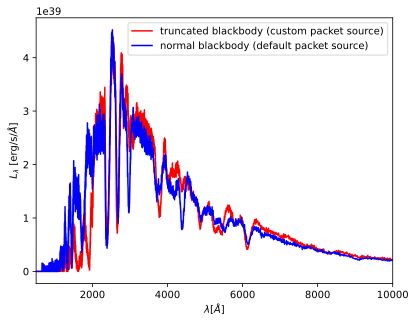

In [6]:
%matplotlib inline
plt.plot(mdl.spectrum_solver.spectrum_virtual_packets.wavelength,
         mdl.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
         color='red', label='truncated blackbody (custom packet source)')
plt.plot(mdl_norm.spectrum_solver.spectrum_virtual_packets.wavelength,
         mdl_norm.spectrum_solver.spectrum_virtual_packets.luminosity_density_lambda,
         color='blue', label='normal blackbody (default packet source)')
plt.xlabel('$\lambda [\AA]$')
plt.ylabel('$L_\lambda$ [erg/s/$\AA$]')
plt.xlim(500, 10000)
plt.legend()